In [54]:
import cv2
import os
import numpy as np
from tqdm import tqdm
import json
from matplotlib import pyplot as plt

import sys
sys.path.insert(0, '../')
from inference_utils.crop_utils import create_square_crop_by_detection

%matplotlib inline

In [55]:
def read_image(img_p: str) -> np.ndarray:
    _img = cv2.imread(img_p, cv2.IMREAD_COLOR)
    assert _img is not None, img_p
    return cv2.cvtColor(_img, cv2.COLOR_BGR2RGB)

def extract_yong_masks(_img: np.ndarray) -> np.ndarray:
    r_channel = _img[..., 0]
    _, rmask = cv2.threshold(r_channel, 250, 255, cv2.THRESH_BINARY)
    r_channel = cv2.inRange(_img, (120, 0, 0), (255, 10, 10))
    return r_channel

In [59]:
dataset_folder = '/media/alexey/SSDDataDisk/datasets/walruses/yung_classification/classification/'
young_folder = os.path.join(dataset_folder, 'young/')
older_folder = os.path.join(dataset_folder, 'older/')

os.makedirs(young_folder, exist_ok=True)
os.makedirs(older_folder, exist_ok=True)

5610


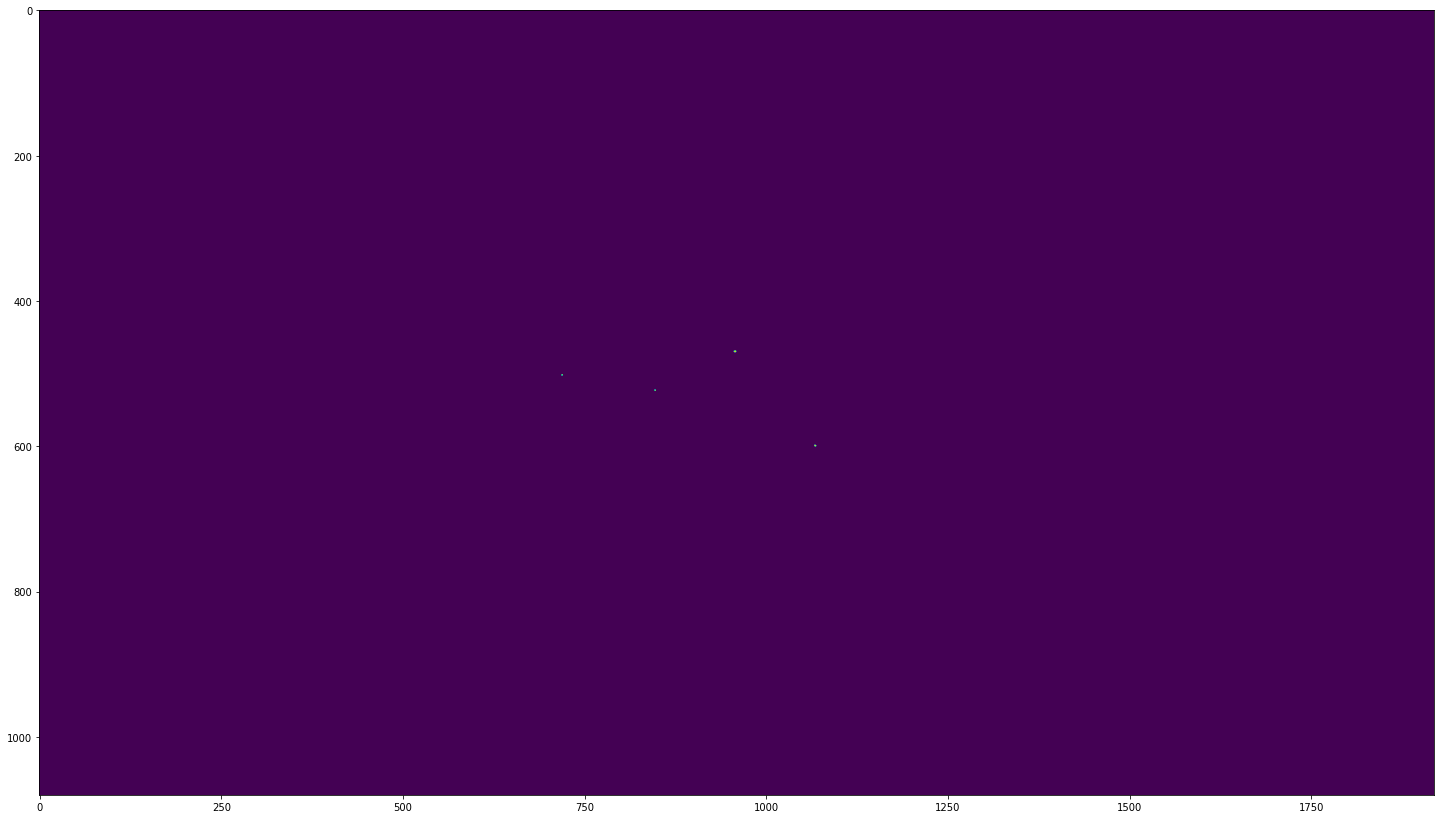

In [57]:
images_folder = '/media/alexey/SSDDataDisk/datasets/walruses/yung_classification/images/'
original_images_folder = '/media/alexey/SSDDataDisk/datasets/walruses/raw/images/'
markup_folder = '/media/alexey/SSDDataDisk/datasets/walruses/raw/markup/'

images_names = [os.path.splitext(p)[0] for p in os.listdir(images_folder)]

img = read_image(os.path.join(images_folder, images_names[0] + '.jpg'))

print(extract_yong_masks(img).sum())

plt.figure(figsize=(25, 20))
plt.imshow(extract_yong_masks(img))
plt.show()

In [60]:
for name in tqdm(images_names):
    orig_img = read_image(os.path.join(original_images_folder, name + '.jpg'))
    with open(os.path.join(markup_folder, name + '.json'), 'r') as jf:
              markup_data = json.load(jf)
            
    img = read_image(os.path.join(images_folder, name + '.jpg'))
    rmask = extract_yong_masks(img)
    
    for i, d in enumerate(markup_data):
        x1, y1, w, h = [int(e) for e in d['bbox'][:4]]
        x2, y2 = x1 + w, y1 + h
        
        if h * w < 100:
            continue
        
        # crop = orig_img[y1:y2, x1:x2]
        
        crop = create_square_crop_by_detection(orig_img, [x1, y1, x2, y2])
        
        if crop.shape[0] * crop.shape[1] < 100:
            continue
        
        if rmask[y1:y2, x1:x2].sum() > 0:
            target_folder = young_folder
        else:
            target_folder = older_folder
            
        save_path = os.path.join(target_folder, '{}_{}.jpg'.format(name, i + 1))
        assert cv2.imwrite(save_path, cv2.cvtColor(crop, cv2.COLOR_RGB2BGR)), save_path

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:07<00:00,  4.02it/s]


In [61]:
young_samples_count = len(os.listdir(young_folder))
older_samples_count = len(os.listdir(older_folder))

for _ in tqdm(range(older_samples_count - young_samples_count - 1)):
    older_images = os.listdir(older_folder)
    del_idx = np.random.randint(len(older_images))
    os.remove(os.path.join(older_folder, older_images[del_idx]))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5732/5732 [00:07<00:00, 724.96it/s]
